(537, 691, 3)


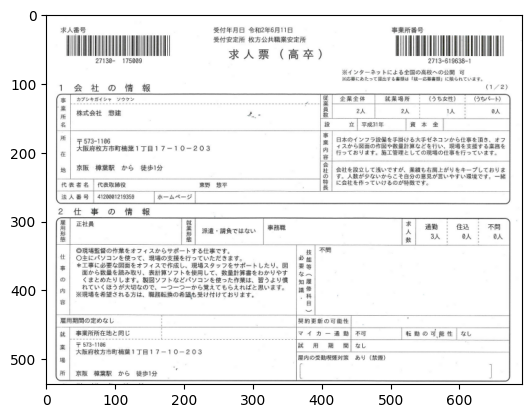

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

root_path = os.getcwd()
image_path = root_path+"/configs/image.png"

cv_img = cv.imread(image_path)
print(cv_img.shape)
plt.imshow(cv_img)


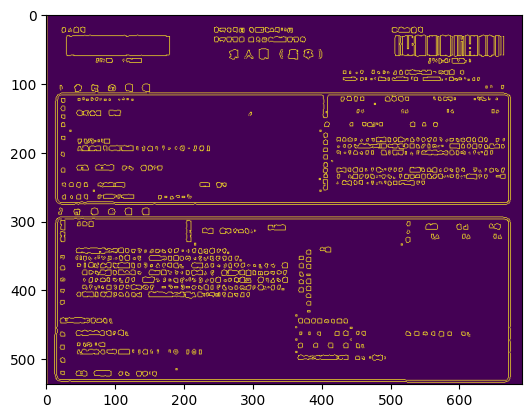

In [2]:
img_copy = cv_img.copy()
# convert to gray color
gray_img = cv.cvtColor(img_copy,cv.COLOR_RGB2GRAY)

# make gussianblur.(Normalized colors or noise reduce)
blurred_img = cv.GaussianBlur(gray_img,(5,5), 0)

# Perform Thresholding (Weak lines are disappeared)
thresh = cv.threshold(blurred_img, 200, 255, cv.THRESH_BINARY)[1]

# perform biletral filter
gray = cv.bilateralFilter(thresh,1,100,150)

# Perform Canny Edges Detection (Clear lines become more clear)
img_threshold = cv.Canny(gray,10,210)
plt.imshow(img_threshold)

In [3]:
def reorder(myPoints):


    # Reshape [[[22 22]]] into [[22 22]]
    myPoints = myPoints.reshape((4, 2))
    # initialize
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    # add x and y for each point
    add = myPoints.sum(1)

    # Find smallest value of  x+y for top_left corner
    myPointsNew[0] = myPoints[np.argmin(add)]
    
    # Find largest value of  x+y for bottom_right corner
    myPointsNew[3] = myPoints[np.argmax(add)]
    
    diff = np.diff(myPoints, axis=1)
    
    # Find smallest value of  x+y for top_right corner
    myPointsNew[1] = myPoints[np.argmin(diff)]
    
    # Find largest value of  x+y for bottom_left corner
    myPointsNew[2] = myPoints[np.argmax(diff)]

    print("Reorder :",myPointsNew)

    return myPointsNew

Reorder : [[[ 14 299]]

 [[668 295]]

 [[ 18 532]]

 [[673 529]]]
Reorder : [[[ 16 124]]

 [[666 117]]

 [[ 20 273]]

 [[671 271]]]


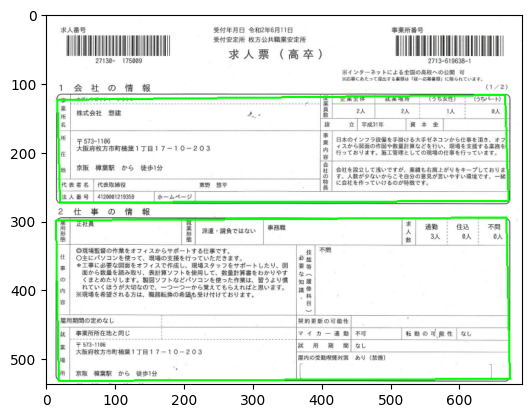

In [4]:
# What are contours?
# Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity.
# The contours are a useful tool for shape analysis and object detection and recognition.
contours ,hierarchy = cv.findContours(img_threshold,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

rgb = cv_img.copy()
rect_list = []

for i in contours:
    area = cv.contourArea(i)

    if area > 8000:
        peri = cv.arcLength(i,True)

        approx = cv.approxPolyDP(i, 0.02 * peri,True)
        #print(approx)
        
        if len(approx) ==  4:
            cv.drawContours(rgb, [approx],-1,(0,255,0),2)
            #print("Result :",type(approx[:4]))
        rect_list.append(reorder(approx[:4]))

plt.imshow(rgb)

[array([[[ 14, 299]],

       [[668, 295]],

       [[ 18, 532]],

       [[673, 529]]], dtype=int32), array([[[ 16, 124]],

       [[666, 117]],

       [[ 20, 273]],

       [[671, 271]]], dtype=int32)]
Rect  [ 16 124]


True

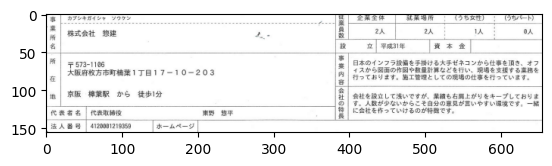

In [5]:
crop_img = cv_img.copy()

index = 1

rect_result = rect_list
print(rect_result)
print("Rect ",rect_result[index][0][0])

x_indexs = [rect_list[index][0][0][0],rect_list[index][1][0][0],rect_list[index][2][0][0],rect_list[index][3][0][0]]

y_indexs = [rect_list[index][0][0][1],rect_list[index][1][0][1],rect_list[index][2][0][1],rect_list[index][3][0][1]]

x1 = np.min(x_indexs)
x2 = np.max(x_indexs)
y1 = np.min(y_indexs)
y2 = np.max(y_indexs)

# Crop image with 4 points from above and keep channel to default
cropped_img = crop_img[y1:y2,x1:x2,:]
plt.imshow(cropped_img)

# Save Cropped image

cv.imwrite("configs/block_1.jpg",cropped_img)


In [6]:
#!pip install python-dotenv
#!pip install google-cloud-vision

In [7]:
from dotenv import load_dotenv

print(load_dotenv())
print(os.getenv('GOOGLE_APPLICATION_CREDENTIALS'))

True
/Users/myothiha/Desktop/Machine-Learning-In-Production/02_Prod_Dev_Envs_Setup/test_env_one/credential/service_account.json


In [8]:
import io
from google.cloud import vision
from google.oauth2 import service_account


img_path="configs/block_1.png"

# Load credentials from JSON key file
cred_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")  # note the 'S' at the end
credentials = service_account.Credentials.from_service_account_file(cred_path)

# Create Vision API client with credentials
client = vision.ImageAnnotatorClient(credentials=credentials)

# Load the image
img_path = "configs/block_1.png"
with io.open(img_path, 'rb') as image_file:
    content = image_file.read()

image = vision.Image(content=content)


In [9]:
response = client.text_detection(image=image)
response

text_annotations {
  locale: "ja"
  description: "カブシキガイシャ ソウケン\n株式会社 惣建\n所\n名\n所\n〒573-1106\n大阪府枚方市町楠葉1丁目17-10-203\n在\n地\n京阪 樟葉駅 から 徒歩1分\n代表者名 代表取締役\n法人番号\n4120001219359\n東野想平\nホームページ\n企業全体\n就菜場所\n2人\n2人\n(うち女性)\n人\n(うちパート)\n0人\n設\n立平成31年\n資本金\n従業員数 事内容 会社の特長\n日本のインフラ設備を手掛ける大手ゼネコンから仕事を頂き、 オフ\nィスから図面の作図や数量計算などを行い、 現場を支援する業務を\n内行っております。 施工管理としての現場の仕事を行っています。\n会社を設立して浅いですが、 業績も右肩上がりをキープしておりま\nす。人数が少ないからこそ自分の意見が言いやすい環境です。 一緒\nに会社を作っていけるのが特徴です。"
  bounding_poly {
    vertices {
      x: 4
    }
    vertices {
      x: 651
    }
    vertices {
      x: 651
      y: 152
    }
    vertices {
      x: 4
      y: 152
    }
  }
}
text_annotations {
  description: "カブシキガイシャ"
  bounding_poly {
    vertices {
      x: 28
      y: 3
    }
    vertices {
      x: 78
      y: 3
    }
    vertices {
      x: 78
      y: 10
    }
    vertices {
      x: 28
      y: 10
    }
  }
}
text_annotations {
  description: "ソウケン"
  bounding_poly {
    vertices {
      x: 84
      y: 3
    }
    vertices {
      x

In [10]:
import json

def load_template_frame(jsonTemplate_path):

    block_shapes = None

    template_infos = []

    with open(jsonTemplate_path,'r') as json_file :
        data = json.load(json_file)
        block_shapes = data['shapes']

    for data in block_shapes:
       label = data['label']
       points =  data['points']

       x,y,x1,y1 = int(points[0][0]),int(points[0][1]),int(points[1][0]),int(points[1][1])
       template_infos.append([label,x,y,x1,y1])
    
    return template_infos

jsonTemplate_path = os.getcwd()+"/template/block_1.json"
template_infos = load_template_frame(jsonTemplate_path)
print(template_infos)




[['1b_01', 1, 0, 47, 110], ['1b_02', 47, 0, 874, 31], ['1b_03', 48, 30, 872, 110], ['1b_04', 874, 2, 912, 76], ['1b_05', 910, 1, 1053, 31], ['1b_06', 911, 30, 1054, 75], ['1b_07', 1055, 1, 1201, 31], ['1b_08', 1054, 32, 1201, 75], ['1b_09', 1203, 1, 1349, 32], ['1b_10', 1203, 32, 1348, 77], ['1b_11', 1349, 0, 1498, 31], ['1b_12', 1498, 77, 1349, 30], ['1b_13', 874, 75, 995, 114], ['1b_14', 998, 75, 1158, 111], ['1b_15', 1158, 75, 1279, 112], ['1b_16', 1280, 76, 1498, 114], ['1b_17', 0, 109, 46, 259], ['1b_18', 47, 110, 873, 262], ['1b_19', 912, 207, 874, 113], ['1b_20', 914, 113, 1498, 208], ['1b_21', 873, 208, 911, 299], ['1b_22', 912, 207, 1498, 301], ['1b_23', 1, 259, 122, 297], ['1b_24', 124, 261, 872, 300], ['1b_25', 1, 297, 123, 334], ['1b_26', 123, 297, 323, 335], ['1b_27', 324, 299, 459, 335], ['1b_28', 460, 299, 1499, 335]]


In [11]:
def load_xmlResponseText(response):
    responseTexts = []
    document = response.full_text_annotation
    #print(document)
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                         vertices = word.bounding_box.vertices

                         xs = [v.x for v in vertices if v.x is not None]
                         ys = [v.y for v in vertices if v.y is not None]
                         if len(xs) < 4 or len(ys) < 4:
                             continue
                         
                         xmin = min(xs)
                         xmax = max(xs)
                         ymin = min(ys)
                         ymax = max(ys)
                         
                         xcenter = (xmin + xmax) 
                         ycenter = (ymin + ymax) 
                         text = symbol.text
                         #text = ''.join([s.text for s in word.symbols])

                         responseTexts.append([text, xcenter, ycenter])
    return responseTexts


responseText_infos = load_xmlResponseText(response)
responseText_infos

[['カ', 106, 13],
 ['ブ', 106, 13],
 ['シ', 106, 13],
 ['キ', 106, 13],
 ['ガ', 106, 13],
 ['イ', 106, 13],
 ['シ', 106, 13],
 ['ャ', 106, 13],
 ['ソ', 195, 12],
 ['ウ', 195, 12],
 ['ケ', 195, 12],
 ['ン', 195, 12],
 ['株', 92, 53],
 ['式', 92, 53],
 ['会', 92, 53],
 ['社', 92, 53],
 ['惣', 167, 53],
 ['建', 167, 53],
 ['所', 18, 64],
 ['名', 16, 86],
 ['所', 17, 126],
 ['〒', 103, 134],
 ['5', 103, 134],
 ['7', 103, 134],
 ['3', 103, 134],
 ['-', 103, 134],
 ['1', 103, 134],
 ['1', 103, 134],
 ['0', 103, 134],
 ['6', 103, 134],
 ['大', 72, 155],
 ['阪', 72, 155],
 ['府', 102, 155],
 ['枚', 128, 155],
 ['方', 128, 155],
 ['市', 158, 155],
 ['町', 193, 155],
 ['楠', 193, 155],
 ['葉', 193, 155],
 ['1', 232, 155],
 ['丁', 260, 155],
 ['目', 260, 155],
 ['1', 365, 155],
 ['7', 365, 155],
 ['-', 365, 155],
 ['1', 365, 155],
 ['0', 365, 155],
 ['-', 365, 155],
 ['2', 365, 155],
 ['0', 365, 155],
 ['3', 365, 155],
 ['在', 17, 171],
 ['地', 18, 219],
 ['京', 73, 211],
 ['阪', 73, 211],
 ['樟', 127, 211],
 ['葉', 127, 211],
 ['駅', 

In [12]:
def match_Template(template_infos,responseText_infos):
    result_dict = {}
    for bbox in template_infos:
        label, xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3], bbox[4]
        texts = ''
        for text_info in responseText_infos:
            text = text_info[0]
            xcenter = text_info[1]
            ycenter = text_info[2]
            if xmin <= xcenter <= xmax and ymin <= ycenter <= ymax:
                texts += text + ' '
            result_dict[label] = str(texts).strip()

    
    return  result_dict
result_dict = match_Template(template_infos,responseText_infos)
(result_dict)

{'1b_01': '所 名',
 '1b_02': 'カ ブ シ キ ガ イ シ ャ ソ ウ ケ ン 企 業 従 業',
 '1b_03': '株 式 会 社 惣 建 2 設 立 員 数',
 '1b_04': '全 体 人',
 '1b_05': '就 菜 場 所',
 '1b_06': '2 人',
 '1b_07': '( う ち 女 性 )',
 '1b_08': '人',
 '1b_09': '( う ち パ ー ト )',
 '1b_10': '0 人',
 '1b_11': '',
 '1b_12': '',
 '1b_13': '平 成 3 1 年',
 '1b_14': '資 本 金',
 '1b_15': '',
 '1b_16': '',
 '1b_17': '所 在 地',
 '1b_18': '〒 5 7 3 - 1 1 0 6 大 阪 府 枚 方 市 町 楠 葉 1 丁 目 1 7 - 1 0 - 2 0 3 京 阪 樟 葉 駅 か ら 徒 歩 1 分 者 名 代 表 取 締 役 東 野 想 平 事 内 容 会 社 の 特 長 日 本 の ィ ス か ら 内 行 っ て お り 会 社 を す 。 人 数 に 会 社 を',
 '1b_19': '',
 '1b_20': '設 備 を 手 掛 け る 大 手 ゼ ネ コ ン か ら 仕 事 を 頂 き 、 オ フ の 作 図 や 数 量 計 算 な ど を 行 い 、 現 場 を 支 援 す る 業 務 を 。 施 工 管 理 と し て の 現 場 の 仕 事 を 行 っ て い ま す 。',
 '1b_21': '設 立 し が 作 っ',
 '1b_22': 'て 浅 い で す が 、 業 績 も 右 肩 上 が り を キ ー プ し て お り ま 少 な い か ら こ そ 自 分 の 意 見 が 言 い や す い 環 境 で す 。 一 緒 て い け る の が 特 徴 で す 。',
 '1b_23': '代 表 者 名 法 人 番 号',
 '1b_24': '代 表 取 締 役 4 1 2 0 0 0 1 2 1 9 3 5 9 東 野 想 平 ホ ー ム ペ ー ジ',
 '1b_25': '法 人 番 号',
 '1b_26': '4 1 2 0 0 0